# After the loading and inital exploration, let's analyze the data

# 1. Import libraries

In [1]:
# ======================================================
# 1. Import libraries
# ======================================================
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 2. Functions

In [2]:
# ======================================================
# 2. Functions
# ======================================================
def load_city_data(city, temp_dir, wind_dir):
    tx = pd.read_csv(
        f"{temp_dir}{city}_daily_TX_raw.csv",
        parse_dates=["date"]
    )
    wind = pd.read_csv(
        f"{wind_dir}temp_wind_{city.lower()}.csv",
        parse_dates=["date"]
    )
    # We are only able to much if we have 

    # Best station in Marseille: 13001009 (AIX EN PROVENCE).
    # Filter by the best station for file {city}_daily_TX_raw.csv
    # temp_wind_{city}.csv data is already for the station 13001009 (AIX EN PROVENCE)
    tx_best_station = tx[tx['NUM_POSTE'] == 13001009]
    return (
        tx_best_station.merge(wind, on="date", how="inner")
          .sort_values("date")
          .reset_index(drop=True)
    )

# 3. Load data (Marseille)

In [3]:
# ======================================================
# 3. Load data (Marseille)
# ======================================================
TEMP_DIR = "../data/1_outputs/"
WIND_DIR = "../data/2_outputs/"

df_marseille = load_city_data("Marseille", TEMP_DIR, WIND_DIR)

df_marseille.head()

,date,NUM_POSTE,NOM_USUEL,TX,TN,LAT,LON,ALTI,temp_mean_c,temp_max_c,wind_mean_10m_ms,wind_mean_2m_ms,wind_max_hourly_ms,wind_max_inst_ms,wind_gust_3s_ms,wind_dir_max_deg,wind_dir_inst_deg,city
0,1955-07-01,13001009,AIX EN PROVENCE,28.0,11.7,43.5295,5.4245,173,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marseille
1,1955-07-01,13001009,AIX EN PROVENCE,28.0,11.7,43.5295,5.4245,173,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marseille
2,1955-07-01,13001009,AIX EN PROVENCE,28.0,11.7,43.5295,5.4245,173,23.9,30.5,4.1,NaN,NaN,11.0,NaN,NaN,NaN,Marseille
3,1955-07-01,13001009,AIX EN PROVENCE,28.0,11.7,43.5295,5.4245,173,23.8,29.1,3.3,NaN,NaN,11.0,NaN,NaN,340.0,Marseille
4,1955-07-01,13001009,AIX EN PROVENCE,28.0,11.7,43.5295,5.4245,173,22.9,29.3,3.0,NaN,NaN,9.0,NaN,NaN,NaN,Marseille


# 4. Explore data

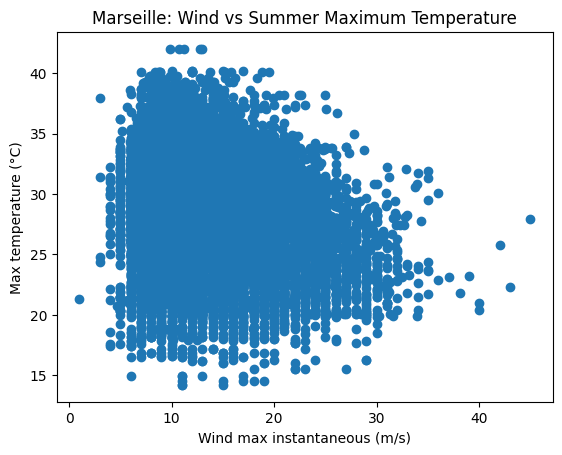

In [4]:

# ======================================================
# 4. Explore data
# ======================================================


# --- Contiue with the Marseille data ---
df = df_marseille.copy()

# Ensure datetime
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.month

# Keep summer months (JJA)
df_summer = df[df["month"].isin([6, 7, 8])]

# --- Choose variables ---
temp_col = "TX"                 # or "temp_max_c" (pick one and be consistent)
wind_col = "wind_max_inst_ms"

# --- Scatter plot ---
plt.figure()
plt.scatter(df_summer[wind_col], df_summer[temp_col])
plt.xlabel("Wind max instantaneous (m/s)")
plt.ylabel("Max temperature (°C)")
plt.title("Marseille: Wind vs Summer Maximum Temperature")
plt.show()

# Interpretation:
# Wind speed is not linearly correlated with summer maximum temperature, 
#but it may act as a limiting factor for extreme heat and may become 
#informative when modelling heatwave occurrence or when using non-linear 
#models such as Random Forests, decision trees, or gradient boosting.

# 5. Find heatwaves

In [5]:

# ======================================================
# 5. Find heatwaves
# ======================================================


df = df_marseille.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

TX_P95 = df["TX"].quantile(0.95)
df["hot_day"] = df["TX"] >= TX_P95

# Explicit consecutive-day counter
df["hot_spell_len"] = 0
count = 0

for i, is_hot in enumerate(df["hot_day"]):
    if is_hot:
        count += 1
    else:
        count = 0
    df.loc[i, "hot_spell_len"] = count

# Heatwave tags: date are greater than or equal to (ge) 3 days.
df["heatwave_ge_3days"] = df["hot_spell_len"] >= 3
df["heatwave_gt_3days"] = df["hot_spell_len"] > 3

# 6. Summer analysis: wind vs temperature with heatwaves

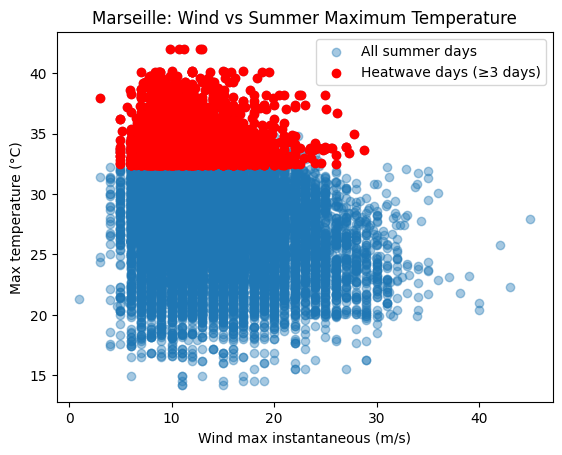

In [6]:
# ======================================================
# 6. Summer analysis: wind vs temperature with heatwaves
# ======================================================



# Recreate summer subset AFTER heatwave tags exist
df["month"] = df["date"].dt.month
df_summer = df[df["month"].isin([6, 7, 8])]

temp_col = "TX"
wind_col = "wind_max_inst_ms"

# All summer days
plt.figure()
plt.scatter(
    df_summer[wind_col],
    df_summer[temp_col],
    alpha=0.4,
    label="All summer days"
)

# Heatwave days (≥ 3 consecutive days)
hw = df_summer[df_summer["heatwave_ge_3days"]]

plt.scatter(
    hw[wind_col],
    hw[temp_col],
    color="red",
    label="Heatwave days (≥3 days)"
)

plt.xlabel("Wind max instantaneous (m/s)")
plt.ylabel("Max temperature (°C)")
plt.title("Marseille: Wind vs Summer Maximum Temperature")
plt.legend()
plt.show()

# 7. ML classification: heatwave occurrence 

wind_mean_10m_ms       4872
wind_max_hourly_ms    11805
wind_max_inst_ms       3599
wind_gust_3s_ms       13719
wind_dir_max_deg      11821
wind_dir_inst_deg      4933
TX                        0
dtype: int64
(32050, 23)
(17894, 7)
(17894, 7)


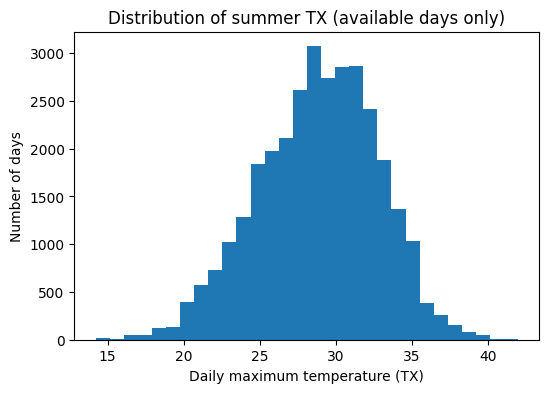

In [7]:
#df.columns

#missing too many data in "wind_mean_2m_ms"
features = [
    "wind_mean_10m_ms",
    "wind_max_hourly_ms",
    "wind_max_inst_ms",
    "wind_gust_3s_ms",
    "wind_dir_max_deg",
    "wind_dir_inst_deg"
]

target = "TX"
# Drop missing values
df_ml = df_summer[features + [target]].dropna()

X = df_ml[features]
y = df_ml[target]

print(df_summer[features + [target]].isna().sum())
print(df_summer.shape)
print(df_ml.shape)

df_ml = df_summer[features + [target]].dropna()
print(df_ml.shape)

# what is the distribution of Tx?
plt.figure(figsize=(6, 4))
plt.hist(df_summer["TX"].dropna(), bins=30)
plt.xlabel("Daily maximum temperature (TX)")
plt.ylabel("Number of days")
plt.title("Distribution of summer TX (available days only)")
plt.show()



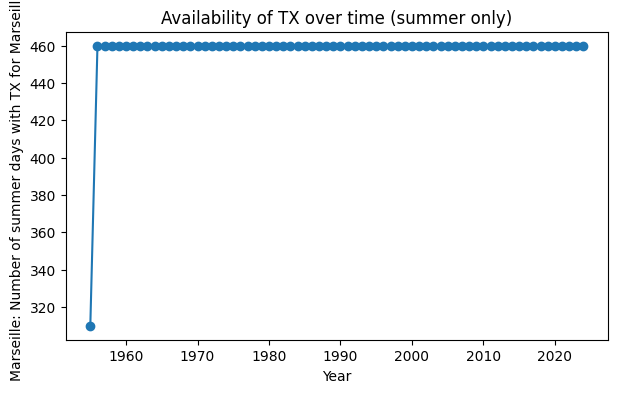

year
1955    0.0
1956    0.0
1957    0.0
1958    0.0
1959    0.0
       ... 
2020    0.0
2021    0.0
2022    0.0
2023    0.0
2024    0.0
Length: 70, dtype: float64


Series([], dtype: float64)

In [8]:
# Better understand Tx
# about 20% of the data missing for 2009-2019
# Interpretation: should not impact heavewaves too much as they are only selected
# When there are 3 days of high temperature. 
# Make sure date is datetime
df_summer = df_summer.copy()
df_summer["year"] = df_summer["date"].dt.year

# Count available TX per year
tx_count_per_year = (
    df_summer["TX"]
    .notna()
    .groupby(df_summer["year"])
    .sum()
)

plt.figure(figsize=(7, 4))
plt.plot(tx_count_per_year.index, tx_count_per_year.values, marker="o")
plt.xlabel("Year")
plt.ylabel("Marseille: Number of summer days with TX for Marseille")
plt.title("Availability of TX over time (summer only)")
plt.show()

# total possible summer days per year (June–Aug)
total_days_per_year = df_summer.groupby("year").size()

# available TX days per year
tx_available = df_summer["TX"].notna().groupby(df_summer["year"]).sum()

# % missing TX
tx_missing_pct = 100 * (1 - tx_available / total_days_per_year)

print(tx_missing_pct)

threshold = 10  # percent
affected_years = tx_missing_pct[tx_missing_pct > threshold]

affected_years

In [9]:



# Train / test split (NO stratify for regression)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

# Model
# Regression not classifiction for continiiys TX values.
# Will use MAE, R² to eveluate. 
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
results_df = pd.DataFrame([{
    "model": "Gradient Boosting (TX regression)",
    "MAE": mean_absolute_error(y_test, y_pred),
    "R2": r2_score(y_test, y_pred)
}])

display(results_df)


# Feature importance
importances = pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=False)


#print("Feature importance")
display(importances)

# Interpretation:
# The Gradient Boosting regression model shows moderate errors (MAE ≈ 2.8 °C)
# and low explained variance (R² ≈ 0.14), indicating that wind variables alone
# capture only a small fraction of daily maximum temperature (TX) variability.
#
# Among the wind features, wind_mean_10m_ms has the highest relative importance,
# suggesting that near-surface wind intensity is the most informative wind-related
# predictor of TX in this dataset. Wind direction variables are of secondary
# importance, likely reflecting higher variability and regime dependence.
#
# Next steps:
# 1. Reproduce for the other cities. 
#    Optional: try other models.
# 2. Add a persistence baseline (TX at t−1) to quantify the marginal contribution
#    of wind variables beyond simple temperature correlation.
# 3. If time allows: look to incorporate humidity data, which is expected to play a stronger role in
#    modulating extreme temperatures.
# 4. Beyond the scope of this work: look for data availability, extend the analysis to r
#    adiative drivers (e.g. cloud cover and incoming solar radiation) to determine their impact on 
#    the results. 
# 5. R2 =0.14 is weak


,model,MAE,R2
0,Gradient Boosting (TX regression),2.76267,0.18051


wind_mean_10m_ms      0.256740
wind_gust_3s_ms       0.248368
wind_dir_max_deg      0.230616
wind_max_hourly_ms    0.093819
wind_max_inst_ms      0.087002
wind_dir_inst_deg     0.083457
dtype: float64